# Meridional transport
V1: Aviv Solodoch 2020-12

V6ryf: 2021-10

In [1]:
print('Ready')

Ready


In [2]:
%matplotlib inline

import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
#from celluloid import Camera
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cft
import numpy as np
import scipy as sp
import scipy.stats as sp_stats
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from dask.distributed import Client
import dask
dask.config.set({'temporary_directory': '/scratch/g40/as2408'})
from eofs.xarray import Eof

In [3]:
# # client = Client()#n_workers=24)
# client = Client(n_workers=24)
# client

import os
threads_per_worker = 1# Edit as desired

client = Client(
        n_workers=int(os.environ['PBS_NCPUS'])//threads_per_worker,
        threads_per_worker=threads_per_worker,
        memory_limit=f'{3.9*threads_per_worker}gb',
        local_directory=os.path.join(os.environ['PBS_JOBFS'],
                                     'dask-worker-space')
    )
client


Client Scheduler: tcp://127.0.0.1:42679 Dashboard: /proxy/8787/status,Cluster Workers: 16 Cores: 16 Memory: 58.11 GiB


In [4]:
# start_time = '1998-02-01'; end_time   = '2000-01-31'
# start_time = '1958-01-01'; end_time   = '2019-01-01'
# dbfn = '/home/552/as2408/ExpAabwTracers/cyc3_2021-06-09.db'
# session = cc.database.create_session(dbfn)
expt = '01deg_jra55v13_ryf9091'; fn_expsuff = '_ryf9091'
session = cc.database.create_session()

start_time = '2150-01-01'; end_time   = '2180-01-01'
start_time = '2120-01-01'; end_time   = '2180-01-01'
start_time = '2170-01-01'; end_time   = '2180-01-01'
start_time = '2000-01-01'; end_time   = '2009-12-31'
freq = '1 monthly'# '1 daily'
freqstr = 'monthly'; freq = '1 '+freqstr; freqstr = '_'+freqstr
r = 6371 # Radius of the Earth in km

AnFold='/home/552/as2408/SOMixing/01deg_jra55v13_ryf9091/MeridTransport/' #Output figs etc here
rho = 1025 # mean density of sea-water in kg/m^3. For normalization of transport values to Sv

### Calculate density bin half-width

In [5]:
potrho_edges = cc.querying.getvar(expt=expt, variable='potrho_edges', session=session, n=-1)
potrho = cc.querying.getvar(expt=expt, variable='potrho', session=session, n=-1)
dpotrho = np.unique(potrho.values[1:]-potrho.values[0:-1])/2 #0.0625
print(dpotrho)
dpotrho = dpotrho[0]
print(potrho_edges.values[72:75])
print(potrho.values[72:74])
print(1037.0625-dpotrho)
print(1037.1875-dpotrho)

[0.0625]
[1037.    1037.125 1037.25 ]
[1037.0625 1037.1875]
1037.0
1037.125


In [6]:
expt

'01deg_jra55v13_ryf9091'

In [ ]:
# from cosima_cookbook import explore
# ee = explore.ExerimentExplorer(session=session_explore, experiment=expt)
# ee

In [9]:
# neutral = cc.querying.getvar(expt=expt, variable='neutral', 
#                           session=session, frequency='1 monthly',
#                           start_time='2018-11-31 00:00:00', 
#                           end_time='2018-12-31 00:00:00')

In [10]:
# psi = cc.querying.getvar(expt=expt, variable='u', 
#                           session=session, frequency='1 monthly')
# #                           start_time='1962-01-31 00:00:00', 
# #                           end_time='2000-09-30 00:00:00',chunks={'potrho': None})
# print(psi.time[0])
# print(psi.time[-1])
# print(psi.shape)

### Load bathymetry information.

In [11]:
kmt = cc.querying.getvar(expt,'kmt',session, n=-1).fillna(1.0).astype(int) - 1
kmt.load()

In [7]:
ht = cc.querying.getvar(expt, 'ht', session,n=-1)

In [8]:
xt_ocean = ht.xt_ocean; yt_ocean = ht.yt_ocean

### Prepare south polar stereographic projection with circular cutout

In [13]:
# function to make boundary path
# make a path around boundary to create a sector map, then cut it out
def make_boundary_path(lons,lats):
    boundary_path = np.array([lons[-1,:],lats[-1,:]])
    boundary_path = np.append(boundary_path,np.array([lons[::-1,-1],lats[::-1,-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[1,::-1],lats[1,::-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[:,1],lats[:,1]]),axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path

In [14]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor='black', facecolor='gray', linewidth=0.5)

In [15]:
def add_ax_bg(ax,lat1,lat2):
    ax.set_extent([-280, 80, lat1, lat2], crs=ccrs.PlateCarree())
    ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
    ax.coastlines(resolution='50m')
    ax.gridlines()

    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be permanently circular.
    ax.set_boundary(circle, transform=ax.transAxes)

In [16]:
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [17]:
# start_time='2008-01-16 12:00:00'; end_time='2018-12-16 12:00:00'
# ty_trans_rho = cc.querying.getvar(expt, 'ty_trans_rho', session, frequency='1 monthly',
#                   start_time=start_time,end_time=end_time)
# print(ty_trans_rho.time.values[0])
# print(ty_trans_rho.time.values[-1])

In [18]:
# ty_trans_rho.potrho.values==1037.1875#==1037.0625

In [19]:
# ty_trans_rho.potrho.values==1037.0625#1037.1875#==

# Superimpose Eulerian and Eddy meridional transports (accumulated eastward)

In [9]:
potrhothresh_cent = 1037.1875#1037.0625#1037.0625
potrhothresh_top = potrhothresh_cent - dpotrho
# start_time='1958-01-16 12:00:00'; end_time='2018-12-16 12:00:00'
# start_time='1958-01-16 12:00:00'; end_time='1968-12-16 12:00:00'
# start_time='1998-01-16 12:00:00'; end_time='2018-12-16 12:00:00'
start_time='2010-01-01 12:00:00'; end_time='2019-12-31 12:00:00'
lats = [-52,-54,-56,-58,-60,-60.5,-60.7,-61.5,-62,-64,-66] #N
# lats = [-50]#[-54,-56,-58,-60,-60.5,-60.7,-61.5,-62,-64,-66] #N
timeslice = slice(start_time,end_time)
lat = -60
fn = AnFold+'Trans'+str(lat)+'N_underSig2'+str(potrhothresh_top)+'_CumEulerAndEddy'+start_time[0:4]+'to'+end_time[0:4]+'.png'
fn

'/home/552/as2408/SOMixing/01deg_jra55v13_ryf9091/MeridTransport/Trans-60N_underSig21037.125_CumEulerAndEddy2010to2019.png'

In [15]:
lats = np.arange(-66,-48,2)#-50]#[-54,-56,-58,-60,-60.5,-60.7,-61.5,-62,-64,-66] #N
lats

array([-66, -64, -62, -60, -58, -56, -54, -52, -50])

In [ ]:
%%time
LoadPrev = 0
potrhothresh_cent = 1037.1875##1037.0625
potrhothresh_top = potrhothresh_cent - dpotrho
# start_time='1958-01-16 12:00:00'; end_time='2018-12-16 12:00:00'
# start_time='1958-01-16 12:00:00'; end_time='1968-12-16 12:00:00'
# start_time='1998-01-16 12:00:00'; end_time='2018-12-16 12:00:00'
lats = [-52,-54,-56,-58,-60,-60.5,-60.7,-61.5,-62,-64,-66] #N
# lats = [-60.7]#,-60.7,-61.5,-62,-64,-66] #N
# lats = np.arange(-66,-48,2)#-50]#[-54,-56,-58,-60,-60.5,-60.7,-61.5,-62,-64,-66] #N
PlotTotal = 1
for lat in lats:
    FnData = AnFold+'Trans'+str(lat)+'N_underSig2'+str(potrhothresh_top)+'_Cum_'+start_time[0:4]+'to'+end_time[0:4]
    if LoadPrev==1:
        MeridTrans = xr.open_dataset(FnData+'.nc')
        ty_trans_rho = MeridTrans['ty_trans_rho']; ty_trans = MeridTrans['ty_trans']
    else:   
        ty_trans_rho = cc.querying.getvar(expt, 'ty_trans_rho', session, frequency='1 monthly',
                          start_time=start_time,end_time=end_time)
        ty_trans = cc.querying.getvar(expt, 'ty_trans', session, frequency='1 monthly',
                          start_time=start_time,end_time=end_time)
        pot_rho_2 = cc.querying.getvar(expt, 'pot_rho_2', session, frequency='1 monthly',
                          start_time=start_time,end_time=end_time)
        ty_trans_rho = ty_trans_rho.sel(time=timeslice)
        ty_trans = ty_trans.sel(time=timeslice)
        pot_rho_2 = pot_rho_2.sel(time=timeslice)
        #Limit to lat-section and average in time
        ty_trans = ty_trans.sel(yu_ocean=lat,method='nearest').mean('time')/(1e6*rho) # converts kg/s to Sv
        ty_trans_rho = ty_trans_rho.sel(grid_yu_ocean=lat,method='nearest').mean('time')/(1e6*rho) # converts kg/s to Sv
        pot_rho_2 = pot_rho_2.interp(yt_ocean=ty_trans.yu_ocean.values,method='linear').mean('time')
        #Sum transport at densities above threshold
        ty_trans = ty_trans.where(pot_rho_2>=potrhothresh_top,0).sum('st_ocean'); ty_trans.load()
        ty_trans_rho = ty_trans_rho.where(ty_trans_rho.potrho>=potrhothresh_cent,0).sum('potrho'); ty_trans_rho.load()
    ht_sec = ht.interp(yt_ocean=ty_trans_rho.grid_yu_ocean.values)
    #Calculate cumulative meridional transport due to Lagrangian, Eulerian, and (their difference=) eddy transport terms
    ty_transSum = ty_trans.cumsum('xt_ocean'); 
    ty_trans_rhoSum = ty_trans_rho.rename({'grid_xt_ocean':'xt_ocean'}).cumsum('xt_ocean')
    ty_transEddySum = ty_trans_rhoSum - ty_transSum; 
    
    #Plot Eulerian and Eddy transport sections on one plot
    fig = plt.figure(figsize = (12, 8)); fig = plt.gcf(); 
    ax1 = plt.subplot(2, 1, 1)
    if PlotTotal==1:
        plt.plot(ty_trans_rhoSum.xt_ocean,ty_trans_rhoSum); 
    plt.plot(ty_transSum.xt_ocean,ty_transSum); 
    plt.plot(ty_transEddySum.xt_ocean,ty_transEddySum); 
    plt.margins(x=0); plt.grid(); 
    plt.ylabel('Cumulative Transport [Sv]'); plt.xlabel('')#('Longitude ($^\circ$N)')
    if PlotTotal==1:
        plt.legend(['Total Isopycnal','Eulerian Mean','Rectified Eddy'])
        plt.title('(a) Deep (rho2>='+str(potrhothresh_top)+') cumulative Total/Eulerian/Eddy transports at '+str(lat)+'N from ' 
              + start_time[0:10] + ' until '+end_time[0:10]+'\n'+expt
              +'. Total transports: Isopcynal='+str(ty_trans_rhoSum[-1].values)+', Eulerian='+str(ty_transSum[-1].values)+', Eddy='+str(ty_transEddySum[-1].values)+' Sv; (b) Bathyemtry');    
    else:
        plt.legend(['Eulerian Mean','Rectified Eddy'])
        plt.title('(a) Deep (rho2>='+str(potrhothresh_top)+') cumulative Eulerian and Eddy transports at '+str(lat)+'N from ' 
              + start_time[0:10] + ' until '+end_time[0:10]+'\n'+expt
              +'. Total transports: Eulerian='+str(ty_transSum[-1].values)+', Eddy='+str(ty_transEddySum[-1].values)+' Sv; (b) Bathyemtry');    

    ax2 = plt.subplot(2, 1, 2)
    l, b, w, h = ax1.get_position().bounds
    d = 0.3; ax2.set_position([l, b-h*d-0.05, w, h*d])
    plt.plot(ht_sec.xt_ocean,-ht_sec,'k'); plt.xlim(ht_sec.xt_ocean[0],ht_sec.xt_ocean[-1])
    plt.xlabel('Longitude'); plt.ylabel('Depth (m)'); 
    fig.savefig(AnFold+'Trans'+str(lat)+'N_underSig2'+str(potrhothresh_top)
                +'_CumEulerAndEddy'+start_time[0:4]+'to'+end_time[0:4]+'.png') 
    
    if LoadPrev==0: #Save data to a netcdf file
        MeridTrans = xr.Dataset(data_vars={'ty_trans_rho': ty_trans_rho, 'ty_trans': ty_trans})
        MeridTrans.to_netcdf(FnData+'.nc')
    

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


#### Paper plot

CPU times: user 716 ms, sys: 175 ms, total: 891 ms
Wall time: 1.14 s


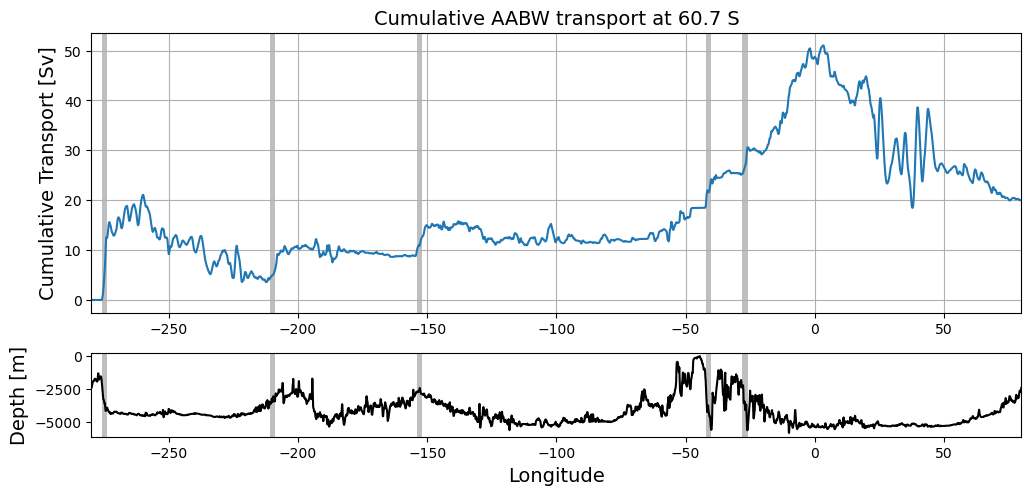

In [15]:
%%time
#Stable version. Unstable is above
LoadPrev = 1
potrhothresh_cent = 1037.1875#1037.0625#1037.0625
potrhothresh_top = potrhothresh_cent - dpotrho
# start_time='1958-01-16 12:00:00'; end_time='2018-12-16 12:00:00'
# start_time='1958-01-16 12:00:00'; end_time='1968-12-16 12:00:00'
# start_time='1998-01-16 12:00:00'; end_time='2018-12-16 12:00:00'
lats = [-60.7]#,-60.7,-61.5,-62,-64,-66] #N
fs = 14
PlotTotal = 1
for lat in lats:
    FnData = AnFold+'Trans'+str(lat)+'N_underSig2'+str(potrhothresh_top)+'_Cum_'+start_time[0:4]+'to'+end_time[0:4]
    if LoadPrev==1:
        MeridTrans = xr.open_dataset(FnData+'.nc')
        ty_trans_rho = MeridTrans['ty_trans_rho']; ty_trans = MeridTrans['ty_trans']
    else:   
        ty_trans_rho = cc.querying.getvar(expt, 'ty_trans_rho', session, frequency='1 monthly',
                          start_time=start_time,end_time=end_time)
        ty_trans = cc.querying.getvar(expt, 'ty_trans', session, frequency='1 monthly',
                          start_time=start_time,end_time=end_time)
        pot_rho_2 = cc.querying.getvar(expt, 'pot_rho_2', session, frequency='1 monthly',
                          start_time=start_time,end_time=end_time)
        #Limit to lat-section and average in time
        ty_trans = ty_trans.sel(yu_ocean=lat,method='nearest').mean('time')/(1e6*rho) # converts kg/s to Sv
        ty_trans_rho = ty_trans_rho.sel(grid_yu_ocean=lat,method='nearest').mean('time')/(1e6*rho) # converts kg/s to Sv
        pot_rho_2 = pot_rho_2.interp(yt_ocean=ty_trans.yu_ocean.values,method='linear').mean('time')
        #Sum transport at densities above threshold
        ty_trans = ty_trans.where(pot_rho_2>=potrhothresh_top,0).sum('st_ocean'); ty_trans.load()
        ty_trans_rho = ty_trans_rho.where(ty_trans_rho.potrho>=potrhothresh_cent,0).sum('potrho'); ty_trans_rho.load()
    ht_sec = ht.interp(yt_ocean=ty_trans_rho.grid_yu_ocean.values)
    #Calculate cumulative meridional transport due to Lagrangian, Eulerian, and (their difference=) eddy transport terms
    ty_transSum = ty_trans.cumsum('xt_ocean'); 
    ty_trans_rhoSum = ty_trans_rho.rename({'grid_xt_ocean':'xt_ocean'}).cumsum('xt_ocean')
    ty_transEddySum = ty_trans_rhoSum - ty_transSum; 
    
    #Plot Eulerian and Eddy transport sections on one plot
    fig = plt.figure(figsize = (12, 8)); fig = plt.gcf(); 
    ax1 = plt.subplot(2, 1, 1)
    if PlotTotal==1:
        plt.plot(ty_trans_rhoSum.xt_ocean,ty_trans_rhoSum); 
#     plt.plot(ty_transSum.xt_ocean,ty_transSum); 
#     plt.plot(ty_transEddySum.xt_ocean,ty_transEddySum); 
    plt.axvspan(-42, -40, color='gray', alpha=0.5, lw=0) #Orkney passage
    plt.axvspan(-28, -26, color='gray', alpha=0.5, lw=0) #East of Scotia Arch
    plt.axvspan(-154, -152, color='gray', alpha=0.5, lw=0) #East of Scotia Arch
    plt.axvspan(-211, -209, color='gray', alpha=0.5, lw=0) #East of Scotia Arch
    plt.axvspan(-276, -274, color='gray', alpha=0.5, lw=0) #East of Scotia Arch
    plt.margins(x=0); plt.grid(); 
    plt.ylabel('Cumulative Transport [Sv]',fontsize=fs); plt.xlabel('')#('Longitude ($^\circ$N)')
#     if PlotTotal==1:
#         plt.legend(['Total Isopycnal','Eulerian Mean','Rectified Eddy'])
#         plt.title('(a) Deep (rho2>='+str(potrhothresh_top)+') cumulative Total/Eulerian/Eddy transports at '+str(lat)+'N from ' 
#               + start_time[0:10] + ' until '+end_time[0:10]+'\n'+expt
#               +'. Total transports: Isopcynal='+str(ty_trans_rhoSum[-1].values)+', Eulerian='+str(ty_transSum[-1].values)+', Eddy='+str(ty_transEddySum[-1].values)+' Sv; (b) Bathyemtry');    
#     else:
#         plt.legend(['Eulerian Mean','Rectified Eddy'])
#         plt.title('(a) Deep (rho2>='+str(potrhothresh_top)+') cumulative Eulerian and Eddy transports at '+str(lat)+'N from ' 
#               + start_time[0:10] + ' until '+end_time[0:10]+'\n'+expt
#               +'. Total transports: Eulerian='+str(ty_transSum[-1].values)+', Eddy='+str(ty_transEddySum[-1].values)+' Sv; (b) Bathyemtry');    
    plt.title('Cumulative AABW transport at 60.7 S',fontsize=fs)
    ax2 = plt.subplot(2, 1, 2)
    l, b, w, h = ax1.get_position().bounds
    d = 0.3; ax2.set_position([l, b-h*d-0.05, w, h*d])
    plt.plot(ht_sec.xt_ocean,-ht_sec,'k'); plt.xlim(ht_sec.xt_ocean[0],ht_sec.xt_ocean[-1])
    plt.axvspan(-42, -40, color='gray', alpha=0.5, lw=0) #Orkney passage
    plt.axvspan(-28, -26, color='gray', alpha=0.5, lw=0) #East of Scotia Arch
    plt.axvspan(-154, -152, color='gray', alpha=0.5, lw=0) #East of Scotia Arch
    plt.axvspan(-211, -209, color='gray', alpha=0.5, lw=0) #East of Scotia Arch
    plt.axvspan(-276, -274, color='gray', alpha=0.5, lw=0) #East of Scotia Arch
    plt.xlabel('Longitude',fontsize=fs); plt.ylabel('Depth [m]',fontsize=fs); 
    fn = 'Trans'+str(lat)+'N_underSig2'+str(potrhothresh_top)
    fn = fn +'_CumEulerAndEddy'+start_time[0:4]+'to'+end_time[0:4]+'_paper' 
    fig.savefig(AnFold+fn+'_B.png',dpi=250,facecolor='w', bbox_inches = 'tight')
    
    if LoadPrev==0: #Save data to a netcdf file
        MeridTrans = xr.Dataset(data_vars={'ty_trans_rho': ty_trans_rho, 'ty_trans': ty_trans})
        MeridTrans.to_netcdf(FnData+'.nc')
    

In [16]:
AnFold+fn+'_B.png'

'/home/552/as2408/ExpAabwTracers/Trans-60.7N_underSig21037.125_CumEulerAndEddy2009to2018_paper_B.png'

In [ ]:
#

In [ ]:
start_time='1998-01-16 12:00:00'; end_time='2018-12-16 12:00:00'
potrhothresh_cent = 1037.1875#1037.0625#1037.0625
potrhothresh_top = potrhothresh_cent - dpotrho
# lats = [-57.5,-57,-56.5,-55.5,-55,-54.5]#66]#[-54,-56,-58,-60,-60.5,-60.7,-61.5,-62,-64,-66] #N
lats = [-50,-52,-54,-54.5,-55,-55.5,-56,-56.5,-57,-57.5,-58,-60,-60.5,-60.7,-61.5,-62,-64,-66] #N
lats = list(range(-30,-52,-2))+lats
TransRho = np.zeros(len(lats)); TransEuler = np.zeros(len(lats)); TransEddy = np.zeros(len(lats))
for nlat in range(len(lats)):
    lat = lats[nlat]
    FnData = AnFold+'Trans'+str(lat)+'N_underSig2'+str(potrhothresh_top)+'_Cum_'+start_time[0:4]+'to'+end_time[0:4]
    MeridTrans = xr.open_dataset(FnData+'.nc')
    ty_trans_rho = MeridTrans['ty_trans_rho']; ty_trans = MeridTrans['ty_trans']
    TransRho[nlat] = ty_trans_rho.sum()
    TransEuler[nlat] = ty_trans.sum()
#     ty_transSum = ty_trans.cumsum('xt_ocean'); 
#     ty_trans_rhoSum = ty_trans_rho.rename({'grid_xt_ocean':'xt_ocean'}).cumsum('xt_ocean')
#     ty_transEddySum = ty_trans_rhoSum - ty_transSum; 
TransEddy = TransRho - TransEuler
# print(ty_trans_rhoSum.values[-1])
# print(ty_transEddySum.values[-1])
# print(ty_transSum.values[-1])

In [ ]:
fig = plt.figure()
plt.plot(lats,TransRho,'o-',lats,TransEuler,'o-',lats,TransEddy,'o-'); plt.grid()
plt.legend(['Isopycnal','Eulerian','Rectified Eddy'])
plt.xlabel('Latitude'); plt.ylabel('Transport [Sv]')
plt.title('AABW transport, beneath '+str(potrhothresh_top)+' kg/m^3.\n From '              
          + start_time[0:10] + ' until '+end_time[0:10]+'\n'+expt)
fig.savefig(AnFold+'TransVsLat_underSig2'+str(potrhothresh_top)
            +start_time[0:4]+'to'+end_time[0:4]+'.png') 

In [ ]:
fig = plt.figure()
plt.plot(lats,TransRho,'o-',lats,TransEuler,'o-',lats,TransEddy,'o-'); plt.grid()
plt.legend(['Isopycnal','Eulerian','Rectified Eddy'])
plt.xlabel('Latitude'); plt.ylabel('Transport [Sv]')
plt.title('AABW transport, beneath '+str(potrhothresh_top)+' kg/m^3.\n From '              
          + start_time[0:10] + ' until '+end_time[0:10]+'\n'+expt)
fig.savefig(AnFold+'TransVsLat_underSig2'+str(potrhothresh_top)
            +start_time[0:4]+'to'+end_time[0:4]+'.png') 

## Add submesoscale transport

Note that the variable 'ty_trans_nrho_submeso' is binned in sigma2 space in this simulation configuration (not nuetral density, as its name, and the name of its vertical variable - "neutral", may suggest.

CPU times: user 28min 6s, sys: 1min 5s, total: 29min 12s
Wall time: 29min 59s


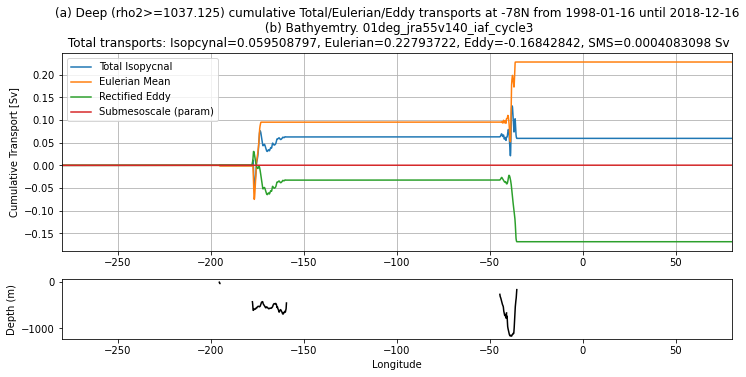

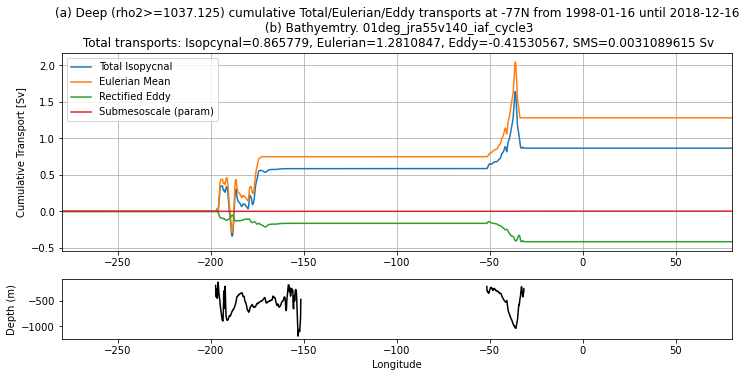

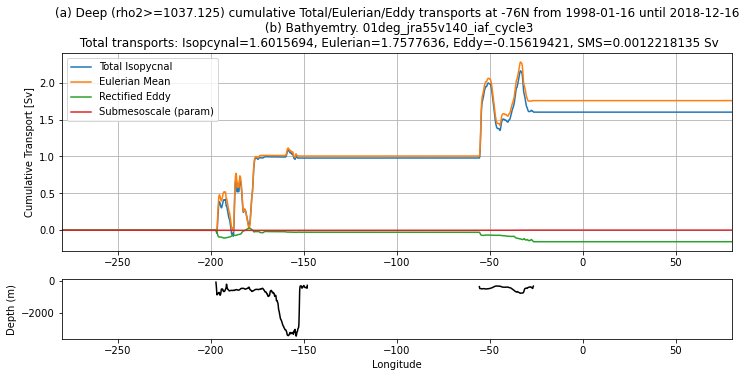

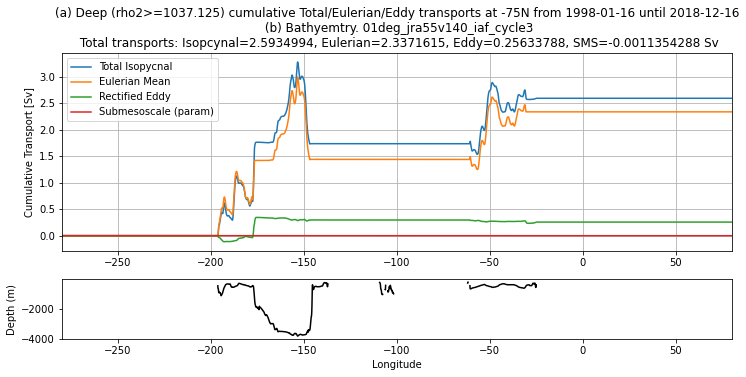

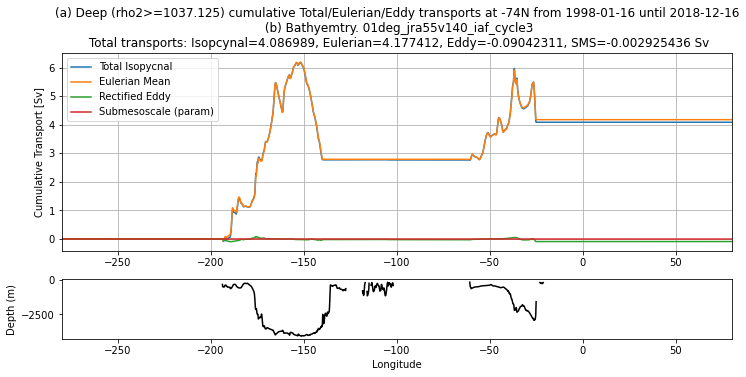

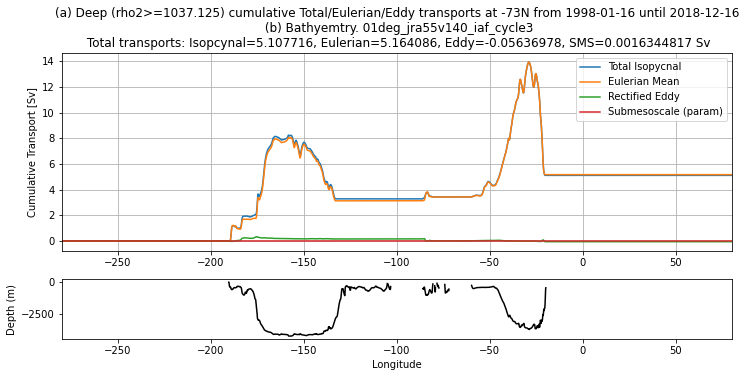

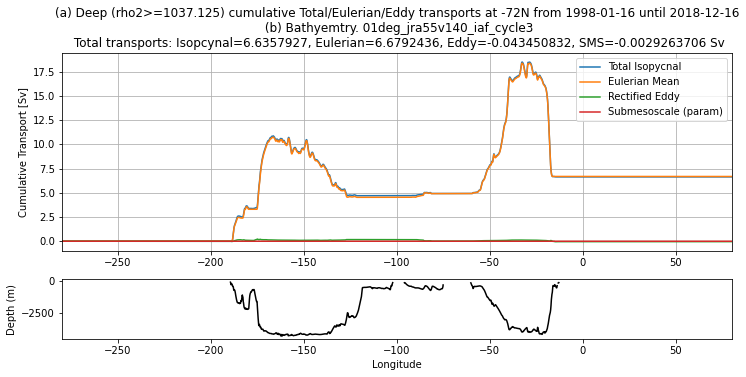

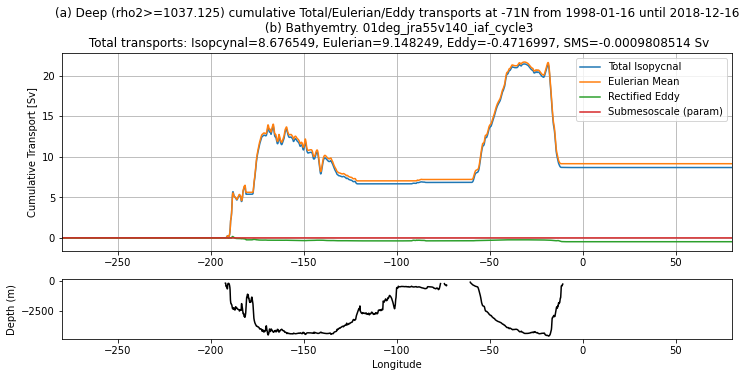

In [14]:
%%time
LoadPrev = 0
potrhothresh_cent = 1037.1875#1037.0625#
potrhothresh_top = potrhothresh_cent - dpotrho
# start_time='1958-01-16 12:00:00'; end_time='2018-12-16 12:00:00'
# start_time='1958-01-16 12:00:00'; end_time='1968-12-16 12:00:00'
start_time='1998-01-16 12:00:00'; end_time='2018-12-16 12:00:00'
lats = [-52,-54,-56,-58,-60,-60.5,-60.7,-61.5,-62,-64,-66] #N
lats = [-50,-52,-54,-56,-58,-60,-60.5,-60.7,-61.5,-62,-64,-66] #N
lats = [-57.5,-57,-56.5,-55.5,-55,-54.5]#66]#[-54,-56,-58,-60,-60.5,-60.7,-61.5,-62,-64,-66] #N
lats = range(-25,50+5,5)
lats = range(-70,-28,2)
lats = range(-42,-28,2)
lats = range(-78,-70,1)
PlotTotal = 1
for lat in lats:
    FnData = AnFold+'Trans'+str(lat)+'N_underSig2'+str(potrhothresh_top)+'_Cum_'+start_time[0:4]+'to'+end_time[0:4]
    if LoadPrev==1:
        MeridTrans = xr.open_dataset(FnData+'.nc')
        ty_trans_rho = MeridTrans['ty_trans_rho']; ty_trans = MeridTrans['ty_trans']
        ty_trans_nrho_submeso = MeridTrans['ty_trans_nrho_submeso']; 
    else:   
        ty_trans_rho = cc.querying.getvar(expt, 'ty_trans_rho', session, frequency='1 monthly',
                          start_time=start_time,end_time=end_time)
        ty_trans = cc.querying.getvar(expt, 'ty_trans', session, frequency='1 monthly',
                          start_time=start_time,end_time=end_time)
        ty_trans_nrho_submeso = cc.querying.getvar(expt, 'ty_trans_nrho_submeso', session, frequency='1 monthly',
                          start_time=start_time,end_time=end_time)
        pot_rho_2 = cc.querying.getvar(expt, 'pot_rho_2', session, frequency='1 monthly',
                          start_time=start_time,end_time=end_time)
        #Limit to lat-section and average in time
        ty_trans_rho = ty_trans_rho.sel(grid_yu_ocean=lat,method='nearest').mean('time')/(1e6*rho) # converts kg/s to Sv
        ty_trans = ty_trans.sel(yu_ocean=lat,method='nearest').mean('time')/(1e6*rho) # converts kg/s to Sv
        ty_trans_nrho_submeso = ty_trans_nrho_submeso.sel(grid_yu_ocean=lat,method='nearest').mean('time')/(1e6*rho) # converts kg/s to Sv
        pot_rho_2 = pot_rho_2.interp(yt_ocean=ty_trans.yu_ocean.values,method='linear').mean('time')
        #Sum transport at densities above threshold
        ty_trans = ty_trans.where(pot_rho_2>=potrhothresh_top,0).sum('st_ocean'); ty_trans.load()
        ty_trans_nrho_submeso = ty_trans_nrho_submeso.where(ty_trans_nrho_submeso.neutral>=potrhothresh_cent,0).sum('neutral'); ty_trans_nrho_submeso.load()
        ty_trans_rho = ty_trans_rho.where(ty_trans_rho.potrho>=potrhothresh_cent,0).sum('potrho'); ty_trans_rho.load()
    ht_sec = ht.interp(yt_ocean=ty_trans_rho.grid_yu_ocean.values)
    #Calculate cumulative meridional transport due to Lagrangian, Eulerian, and (their difference=) eddy transport terms
    ty_transSum = ty_trans.cumsum('xt_ocean'); 
    ty_trans_nrho_submesoSum = ty_trans_nrho_submeso.rename({'grid_xt_ocean':'xt_ocean'}).cumsum('xt_ocean')
    ty_trans_rhoSum = ty_trans_rho.rename({'grid_xt_ocean':'xt_ocean'}).cumsum('xt_ocean')
    ty_transEddySum = ty_trans_rhoSum - ty_transSum; 
    
    #Plot Eulerian and Eddy transport sections on one plot
    fig = plt.figure(figsize = (12, 8)); fig = plt.gcf(); 
    ax1 = plt.subplot(2, 1, 1)
    if PlotTotal==1:
        plt.plot(ty_trans_rhoSum.xt_ocean,ty_trans_rhoSum); 
    plt.plot(ty_transSum.xt_ocean,ty_transSum); 
    plt.plot(ty_transEddySum.xt_ocean,ty_transEddySum); 
    plt.plot(ty_trans_nrho_submesoSum.xt_ocean,ty_trans_nrho_submesoSum); 
    plt.margins(x=0); plt.grid(); 
    plt.ylabel('Cumulative Transport [Sv]'); plt.xlabel('')#('Longitude ($^\circ$N)')
    if PlotTotal==1:
        plt.legend(['Total Isopycnal','Eulerian Mean','Rectified Eddy','Submesoscale (param)'])
        plt.title('(a) Deep (rho2>='+str(potrhothresh_top)+') cumulative Total/Eulerian/Eddy transports at '+str(lat)+'N from ' 
              + start_time[0:10] + ' until '+end_time[0:10]+'\n (b) Bathyemtry. '+expt
              +'\n Total transports: Isopcynal='+str(ty_trans_rhoSum[-1].values)+', Eulerian='+str(ty_transSum[-1].values)
                  +', Eddy='+str(ty_transEddySum[-1].values)+', SMS='+str(ty_trans_nrho_submesoSum[-1].values)+ ' Sv');    
    else:
        plt.legend(['Eulerian Mean','Rectified Eddy','Submesoscale (param)'])
        plt.title('(a) Deep (rho2>='+str(potrhothresh_top)+') cumulative Eulerian and Eddy transports at '+str(lat)+'N from ' 
              + start_time[0:10] + ' until '+end_time[0:10]+'\n (b) Bathyemtry. '+expt
              +'\n Total transports: Eulerian='+str(ty_transSum[-1].values)
                  +', Eddy='+str(ty_transEddySum[-1].values)+', SMS='+str(ty_trans_nrho_submesoSum[-1].values)+' Sv');    

    ax2 = plt.subplot(2, 1, 2)
    l, b, w, h = ax1.get_position().bounds
    d = 0.3; ax2.set_position([l, b-h*d-0.05, w, h*d])
    plt.plot(ht_sec.xt_ocean,-ht_sec,'k'); plt.xlim(ht_sec.xt_ocean[0],ht_sec.xt_ocean[-1])
    plt.xlabel('Longitude'); plt.ylabel('Depth (m)'); 
    fig.savefig(AnFold+'Trans'+str(lat)+'N_underSig2'+str(potrhothresh_top)
                +'_CumEulerAndEddyAndSms'+start_time[0:4]+'to'+end_time[0:4]+'.png') 
    
    if LoadPrev==0: #Save data to a netcdf file
        MeridTrans = xr.Dataset(data_vars={'ty_trans_rho': ty_trans_rho, 'ty_trans': ty_trans,'ty_trans_nrho_submesoSum': ty_trans_nrho_submesoSum})
        MeridTrans.to_netcdf(FnData+'.nc')
    

In [34]:
# !ls -lh /home/552/as2408/ExpAabwTracers/Trans-30N_underSig21037.0_Cum_1998to201*

-rw-r--r-- 1 as2408 v45 110K Jun 23 07:14 /home/552/as2408/ExpAabwTracers/Trans-30N_underSig21037.0_Cum_1998to2018.nc


# Density-bin Eulerian transport

In [ ]:
%%time
start_time='1958-01-16 12:00:00'; end_time='1968-12-16 12:00:00'
# lats = [-52,-54,-56,-58,-60,-60.5,-60.7,-61.5,-62,-64,-66] #N
lat = -60
#Load vars:
pot_rho_2 = cc.querying.getvar(expt, 'pot_rho_2', session, frequency='1 monthly',
                  start_time=start_time,end_time=end_time)
ty_trans = cc.querying.getvar(expt, 'ty_trans', session, frequency='1 monthly',
                  start_time=start_time,end_time=end_time)
ty_trans_rho = cc.querying.getvar(expt, 'ty_trans_rho', session, frequency='1 monthly',
                  start_time=start_time,end_time=end_time)


ty_trans_rho = ty_trans_rho.sel(grid_yu_ocean=lat,method='nearest').mean('time')/(1e6*rho) # converts kg/s to Sv
ty_trans = ty_trans.sel(yu_ocean=lat,method='nearest').mean('time')/(1e6*rho) # converts kg/s to Sv
pot_rho_2 = pot_rho_2.interp(yt_ocean=ty_trans.yu_ocean.values,method='linear').mean('time')


In [ ]:
%%time
ty_trans_rho.load()
ty_trans.load()
pot_rho_2.load()

In [ ]:
%%time
potrho_bins_lims = np.arange(1036.01,1038.03,0.02)
potrho_bins_cents = (potrho_bins_lims[1:]+potrho_bins_lims[0:-1])/2
Nbins = len(potrho_bins_cents); Nlon = ty_trans.shape[1]
ty_trans_binnedonrho = np.zeros((Nbins,Nlon))
for nlon in range(Nlon):
        ty = ty_trans[:,nlon]; prho2n = pot_rho_2[:,nlon]; 
        for nb in range(Nbins):
            ty_b = ty.where(prho2n>=potrho_bins_lims[nb]).where(prho2n<=potrho_bins_lims[nb+1]).sum('st_ocean')
            ty_trans_binnedonrho[nb,nlon] = ty_b

In [ ]:
ty_trans_binnedonrho_sum = np.sum(ty_trans_binnedonrho,1)
ty_trans_rho_sum = ty_trans_rho.sum('grid_xt_ocean')#np.sum(ty_trans_binnedonrho,1)
plt.plot(ty_trans_binnedonrho_sum,potrho_bins_cents,'o-'); plt.grid(); plt.gca().invert_yaxis()
plt.ylim(1037.3,1037)
plt.plot(ty_trans_rho_sum,ty_trans_rho_sum.potrho,'o-')#ty_trans_rho.plot()
plt.legend(['Eulerian','Isopycnal'])
# ty_trans_rho = ty_trans_rho.sum('grid_xt_ocean')
# plt.plot(ty_trans_rho,ty_trans_rho.potrho,'o-')#ty_trans_rho.plot()
# # plt.gca().invert_yaxis()
# plt.ylim([1037.5,1036.5])

In [ ]:
potrhothresh_cent = 1037.1875#1037.0625#
print('Eulerian transprt under '+str(potrhothresh_top)+
      '='+"{:.2f}".format(np.sum(ty_trans_binnedonrho_sum[potrho_bins_cents>=potrhothresh_top]))+' Sv')
print('Eulerian transprt under '+str(potrhothresh_top)+
      '='+"{:.2f}".format(np.sum(ty_trans_binnedonrho_sum[potrho_bins_cents>=potrhothresh_top]))+' Sv')
print('Lagrangian transprt under '+str(potrhothresh)+
      '='+"{:.2f}".format(ty_trans_rho_sum.where(potrho>=potrhothresh_cent).sum('potrho').values)+' Sv')

In [ ]:
potrhothresh = 1037.0625#1037.1875#
print('Eulerian transprt under '+str(potrhothresh_top)+
      '='+"{:.2f}".format(np.sum(ty_trans_binnedonrho_sum[potrho_bins_cents>=potrhothresh_top]))+' Sv')
print('Eulerian transprt under '+str(potrhothresh_top)+
      '='+"{:.2f}".format(np.sum(ty_trans_binnedonrho_sum[potrho_bins_cents>=potrhothresh_top]))+' Sv')
print('Lagrangian transprt under '+str(potrhothresh_top)+
      '='+"{:.2f}".format(ty_trans_rho_sum.where(potrho>=potrhothresh_cent).sum('potrho').values)+' Sv')

In [ ]:
ty_trans_binnedonrho.to_netcdf('ty_trans_binnedonrho.nc')

In [ ]:
%%time
potrho_bins_lims = np.arange(1036.01,1038.03,0.02)
potrho_bins_cents = (potrho_bins_lims[1:]+potrho_bins_lims[0:-1])/2
Nbins = len(potrho_bins_cents); Nlon = ty_trans.shape[1]
ty_trans_binnedonrho = np.zeros((Nbins,Nlon))
nlon = 0
ty = ty_trans[:,nlon]; rho = pot_rho_2[:,nlon]; 
for nb in range(Nbins):
    ty_b = ty.where(rho>=potrho_bins_lims[nb]).where(rho<=potrho_bins_lims[nb+1]).sum('st_ocean')
    ty_trans_binnedonrho[nb,nlon] = ty_b

# Decompose eddy flux to seasonal fluctutations and "eddies"

In [ ]:
%%time
start_time='1962-01-31 00:00:00'; end_time='2000-09-30 00:00:00'
start_time='1962-01-31 00:00:00'; end_time='1980-09-29 00:00:00'
start_time='1980-09-30 00:00:00'; end_time='2000-09-30 00:00:00'
start_time='1981-01-31 00:00:00'; end_time='2018-12-31 00:00:00'
# start_time='1999-09-30 00:00:00'; end_time='2000-09-30 00:00:00'
lats = [-52,-54,-56,-58,-60,-60.5,-61,-61.5,-62,-64,-66] #N
lats = [-52,-54,-56,-58,-60,-60.5,-60.7,-61.5,-62,-64,-66] #N
lats = [-61]
for lat in lats:
    #Load vars:
    ty_trans = cc.querying.getvar(expt, 'ty_trans', session, frequency='1 monthly',
                      start_time=start_time,end_time=end_time)
    ty_trans_rho = cc.querying.getvar(expt, 'ty_trans_rho', session, frequency='1 monthly',
                      start_time=start_time,end_time=end_time)
    pot_rho_2 = cc.querying.getvar(expt, 'pot_rho_2', session, frequency='1 monthly',
                      start_time=start_time,end_time=end_time)
    #Limit to lat-section and average in time
    ty_trans = ty_trans.sel(yu_ocean=lat,method='nearest')/(1e6*rho) # converts kg/s to Sv
    ty_trans_mean = ty_trans.mean('time')
    ty_trans_rho = ty_trans_rho.sel(grid_yu_ocean=lat,method='nearest').mean('time')/(1e6*rho) # converts kg/s to Sv
    pot_rho_2 = pot_rho_2.interp(yt_ocean=ty_trans.yu_ocean.values,method='linear')
    pot_rho_2_mean = pot_rho_2.mean('time')
    ht_sec = ht.interp(yt_ocean=ty_trans.yu_ocean.values)
    #Sum transport at densities above threshold
    ty_trans_mean = ty_trans_mean.where(pot_rho_2_mean>=potrhothresh_top,0).sum('st_ocean'); ty_trans_mean.load()
#     ty_trans_fluc_inter1year = ty_trans.groupby('time.year'); rhogrouped = pot_rho_2.groupby('time.year')
#     ty_trans_fluc_inter1year = ty_trans_fluc_inter1year.where(rhogrouped>=potrhothresh_top,0).sum('st_ocean').mean('time'); 
#     del rhogrouped; ty_trans_fluc_inter1year.load()
    ty_trans_fluc_inter1month = ty_trans.where(pot_rho_2>=potrhothresh_top,0).sum('st_ocean').mean('time'); 
    ty_trans_fluc_inter1month.load()
    ty_trans_rho = ty_trans_rho.where(ty_trans_rho.potrho>=potrhothresh_top,0).sum('potrho'); ty_trans_rho.load()
    #Calculate cumulative meridional transport due to Lagrangian, Eulerian, and (their difference=) eddy transport terms
    ty_transSum = ty_trans_mean.cumsum('xt_ocean'); 
    ty_trans_rhoSum = ty_trans_rho.rename({'grid_xt_ocean':'xt_ocean'}).cumsum('xt_ocean')
    ty_transEddySum = ty_trans_rhoSum - ty_transSum; 
    ty_transFlucInter1monthSum = ty_trans_fluc_inter1month.cumsum('xt_ocean') - ty_transSum; 
#     ty_transFlucInter1yearSum = ty_trans_fluc_inter1year.cumsum('xt_ocean') - ty_transSum; 
    
    #Plot Eulerian and Eddy transport sections on one plot
    fig = plt.figure(figsize = (12, 8)); fig = plt.gcf(); 
    ax1 = plt.subplot(2, 1, 1)
    plt.plot(ty_trans_rhoSum.xt_ocean,ty_trans_rhoSum); 
    plt.plot(ty_transSum.xt_ocean,ty_transSum); 
    plt.plot(ty_transEddySum.xt_ocean,ty_transEddySum); 
    plt.plot(ty_transFlucInter1monthSum.xt_ocean,ty_transFlucInter1monthSum); 
#     plt.plot(ty_transFlucInter1yearSum.xt_ocean,ty_transFlucInter1yearSum); 
    plt.margins(x=0); plt.grid(); 
    plt.legend(['Total Isopycnal','Eulerian Mean','Rectified Eddy','Fluctuations: >1month'])
    plt.ylabel('Cumulative Transport [Sv]'); plt.xlabel('')#('Longitude ($^\circ$N)')
    plt.title('(a) Deep (rho2>='+str(potrhothresh_top)+') cumulative Eulerian and Eddy transports at '+str(lat)+'N from ' 
          + start_time[0:10] + ' until '+end_time[0:10]+'\n'
              +expt+'; (b) Bathyemtry.\n'
          +'Total transports: Isopcynal='+"{:.2f}".format(ty_trans_rhoSum[-1].values)
              +', Eulerian='+"{:.2f}".format(ty_transSum[-1].values)+', Eddy='+"{:.2f}".format(ty_transEddySum[-1].values)    
              +', Fluc>1month='+"{:.2f}".format(ty_trans_fluc_inter1month[-1].values)+' Sv');    
    ax2 = plt.subplot(2, 1, 2)
    l, b, w, h = ax1.get_position().bounds
    d = 0.3; ax2.set_position([l, b-h*d-0.05, w, h*d])
    plt.plot(ht_sec.xt_ocean,-ht_sec,'k'); plt.xlim(ht_sec.xt_ocean[0],ht_sec.xt_ocean[-1])
    plt.xlabel('Longitude'); plt.ylabel('Depth (m)'); 
    fig.savefig(AnFold+'Trans'+str(lat)+'N_underSig2'+str(potrhothresh_top)
                +'_CumTotalEulerEddyDecomposed'+start_time[0:4]+'to'+end_time[0:4]+'.png') 
    

## Add yearly fluctuations as well

In [ ]:
%%time
start_time='1962-01-31 00:00:00'; end_time='2000-09-30 00:00:00'
start_time='1962-01-31 00:00:00'; end_time='1980-09-29 00:00:00'
start_time='1980-09-30 00:00:00'; end_time='2000-09-30 00:00:00'
start_time='1981-01-31 00:00:00'; end_time='2018-12-31 00:00:00'
# start_time='1999-09-30 00:00:00'; end_time='2000-09-30 00:00:00'
lats = [-52,-54,-56,-58,-60,-60.5,-60.7,-61,-61.5,-62,-64,-66] #N
lats = [-62,-64,-66] #N
# lats = [-61]
for lat in lats:
    #Load vars:
    ty_trans = cc.querying.getvar(expt, 'ty_trans', session, frequency='1 monthly',
                      start_time=start_time,end_time=end_time)
    ty_trans_rho = cc.querying.getvar(expt, 'ty_trans_rho', session, frequency='1 monthly',
                      start_time=start_time,end_time=end_time)
    pot_rho_2 = cc.querying.getvar(expt, 'pot_rho_2', session, frequency='1 monthly',
                      start_time=start_time,end_time=end_time)
    #Limit to lat-section and average in time
    ty_trans = ty_trans.sel(yu_ocean=lat,method='nearest')/(1e6*rho) # converts kg/s to Sv
    ty_trans_mean = ty_trans.mean('time')
    ty_trans_rho = ty_trans_rho.sel(grid_yu_ocean=lat,method='nearest').mean('time')/(1e6*rho) # converts kg/s to Sv
    pot_rho_2 = pot_rho_2.interp(yt_ocean=ty_trans.yu_ocean.values,method='linear')
    pot_rho_2_mean = pot_rho_2.mean('time')
    ht_sec = ht.interp(yt_ocean=ty_trans.yu_ocean.values)
    #Sum transport at densities above threshold
    ty_trans_mean = ty_trans_mean.where(pot_rho_2_mean>=potrhothresh_top,0).sum('st_ocean'); ty_trans_mean.load()
#     ty_trans_fluc_inter1year = ty_trans.groupby('time.year').mean('time'); rhogrouped = pot_rho_2.groupby('time.year').mean('time')
#     ty_trans_fluc_inter1year = ty_trans_fluc_inter1year.where(rhogrouped>=potrhothresh_top,0).sum('st_ocean').mean('year'); 
    ty_trans_fluc_inter1year = ty_trans.groupby('time.year').mean('time'); rhogrouped = pot_rho_2.groupby('time.year').mean('time')
    ty_trans_fluc_inter1year = ty_trans_fluc_inter1year.where(rhogrouped>=potrhothresh_top,0).sum('st_ocean').mean('year'); 
    del rhogrouped; ty_trans_fluc_inter1year.load()
    ty_trans_fluc_inter1month = ty_trans.where(pot_rho_2>=potrhothresh_top,0).sum('st_ocean').mean('time'); 
    ty_trans_fluc_inter1month.load()
    ty_trans_rho = ty_trans_rho.where(ty_trans_rho.potrho>=potrhothresh_cent,0).sum('potrho'); ty_trans_rho.load()
    #Calculate cumulative meridional transport due to Lagrangian, Eulerian, and (their difference=) eddy transport terms
    ty_transSum = ty_trans_mean.cumsum('xt_ocean'); 
    ty_trans_rhoSum = ty_trans_rho.rename({'grid_xt_ocean':'xt_ocean'}).cumsum('xt_ocean')
    ty_transEddySum = ty_trans_rhoSum - ty_transSum; 
    ty_transFlucInter1monthSum = ty_trans_fluc_inter1month.cumsum('xt_ocean') - ty_transSum; 
    ty_transFlucInter1yearSum = ty_trans_fluc_inter1year.cumsum('xt_ocean') - ty_transSum; 
    
    #Plot Eulerian and Eddy transport sections on one plot
    fig = plt.figure(figsize = (12, 8)); fig = plt.gcf(); 
    ax1 = plt.subplot(2, 1, 1)
    plt.plot(ty_trans_rhoSum.xt_ocean,ty_trans_rhoSum); 
    plt.plot(ty_transSum.xt_ocean,ty_transSum); 
    plt.plot(ty_transEddySum.xt_ocean,ty_transEddySum); 
    plt.plot(ty_transFlucInter1monthSum.xt_ocean,ty_transFlucInter1monthSum); 
    plt.plot(ty_transFlucInter1yearSum.xt_ocean,ty_transFlucInter1yearSum); 
    plt.margins(x=0); plt.grid(); 
    plt.legend(['Total Isopycnal','Eulerian Mean','Rectified Eddy','Fluctuations: >1month','Fluctuations: >1year'])
    plt.ylabel('Cumulative Transport [Sv]'); plt.xlabel('')#('Longitude ($^\circ$N)')
    plt.title('(a) Deep (rho2>'+str(potrhothresh_top)+') cumulative Eulerian and Eddy transports at '+str(lat)+'N from ' 
          + start_time[0:10] + ' until '+end_time[0:10]+'\n'
              +expt+'; (b) Bathyemtry.\n'
          +'Total transports: Isopcynal='+"{:.2f}".format(ty_trans_rhoSum[-1].values)
              +', Eulerian='+"{:.2f}".format(ty_transSum[-1].values)+', Eddy='+"{:.2f}".format(ty_transEddySum[-1].values)    
              +', Fluc>1month='+"{:.2f}".format(ty_transFlucInter1monthSum[-1].values)
              +', Fluc>1year='+"{:.2f}".format(ty_transFlucInter1yearSum[-1].values)+' Sv');    
    ax2 = plt.subplot(2, 1, 2)
    l, b, w, h = ax1.get_position().bounds
    d = 0.3; ax2.set_position([l, b-h*d-0.05, w, h*d])
    plt.plot(ht_sec.xt_ocean,-ht_sec,'k'); plt.xlim(ht_sec.xt_ocean[0],ht_sec.xt_ocean[-1])
    plt.xlabel('Longitude'); plt.ylabel('Depth (m)'); 
    fig.savefig(AnFold+'Trans'+str(lat)+'N_underSig2'+str(potrhothresh_top)
                +'_CumTotalEulerEddyDecomposed'+start_time[0:4]+'to'+end_time[0:4]+'.png') 
    

## Add 2-monthly,4-monthly fluctuations as well

In [ ]:
%%time
LoadPrev = 0
potrhothresh_cent = 1037.1875#1037.0625#1037.0625
potrhothresh_top = potrhothresh_cent - dpotrho
# start_time='1958-01-16 00:00:00'; end_time='1968-12-16 00:00:00'
start_time='1998-01-16 00:00:00'; end_time='2018-12-16 00:00:00'
# start_time='1999-09-30 00:00:00'; end_time='2000-09-30 00:00:00'
# lats = np.arange(-50,55,5)#[-50,-45,-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,]
lats = [-52,-54,-56,-58,-60,-60.5,-60.7,-61,-61.5,-62,-64,-66] #N
lats = np.arange(-68,58,2)
for lat in lats:
    FnData = AnFold+'Trans'+str(lat)+'N_underSig2'+str(potrhothresh_top)+'_CumTotalEulerEddyDecomposed_'+start_time[0:4]+'to'+end_time[0:4]
    #Load vars:
    ty_trans = cc.querying.getvar(expt, 'ty_trans', session, frequency='1 monthly',
                      start_time=start_time,end_time=end_time)
    ty_trans_rho = cc.querying.getvar(expt, 'ty_trans_rho', session, frequency='1 monthly',
                      start_time=start_time,end_time=end_time)
    pot_rho_2 = cc.querying.getvar(expt, 'pot_rho_2', session, frequency='1 monthly',
                      start_time=start_time,end_time=end_time)
    #Limit to lat-section and average in time
    ty_trans = ty_trans.sel(yu_ocean=lat,method='nearest')/(1e6*rho) # converts kg/s to Sv
    ty_trans_mean = ty_trans.mean('time')
    ty_trans_rho = ty_trans_rho.sel(grid_yu_ocean=lat,method='nearest').mean('time')/(1e6*rho) # converts kg/s to Sv
    pot_rho_2 = pot_rho_2.interp(yt_ocean=ty_trans.yu_ocean.values,method='linear')
    pot_rho_2_mean = pot_rho_2.mean('time')
    ht_sec = ht.interp(yt_ocean=ty_trans_rho.grid_yu_ocean.values)
    #Sum transport at densities above threshold

    ty_trans_mean = ty_trans_mean.where(pot_rho_2_mean>=potrhothresh_top,0).sum('st_ocean'); ty_trans_mean.load()

    ty_trans_fluc_inter1year = ty_trans.groupby('time.year').mean('time'); rhogrouped = pot_rho_2.groupby('time.year').mean('time')
    ty_trans_fluc_inter1year = ty_trans_fluc_inter1year.where(rhogrouped>=potrhothresh_top,0).sum('st_ocean').mean('year'); 
    del rhogrouped; ty_trans_fluc_inter1year.load()

    ty_trans_fluc_inter2month = ty_trans.resample(time='2MS').mean('time'); 
    rhogrouped = pot_rho_2.resample(time='2MS').mean('time'); 
    ty_trans_fluc_inter2month = ty_trans_fluc_inter2month.where(rhogrouped>=potrhothresh_top,0).sum('st_ocean').mean('time');
    del rhogrouped; ty_trans_fluc_inter2month.load()
    
    ty_trans_fluc_inter4month = ty_trans.resample(time='4MS').mean('time'); 
    rhogrouped = pot_rho_2.resample(time='4MS').mean('time'); 
    ty_trans_fluc_inter4month = ty_trans_fluc_inter4month.where(rhogrouped>=potrhothresh_top,0).sum('st_ocean').mean('time'); 
    del rhogrouped; ty_trans_fluc_inter4month.load()
    
    ty_trans_fluc_inter1month = ty_trans.where(pot_rho_2>=potrhothresh_top,0).sum('st_ocean').mean('time'); 
    ty_trans_fluc_inter1month.load()
    ty_trans_rho = ty_trans_rho.where(ty_trans_rho.potrho>=potrhothresh_cent,0).sum('potrho'); ty_trans_rho.load()
    #Calculate cumulative meridional transport due to Lagrangian, Eulerian, and (their difference=) eddy transport terms

    ty_transSum = ty_trans_mean.cumsum('xt_ocean'); 
    ty_trans_rhoSum = ty_trans_rho.rename({'grid_xt_ocean':'xt_ocean'}).cumsum('xt_ocean')
    ty_transEddySum = ty_trans_rhoSum - ty_transSum; 
    ty_transFlucInter1yearSum = ty_trans_fluc_inter1year.cumsum('xt_ocean') - ty_transSum; 
    ty_transFlucInter1monthSum = ty_trans_fluc_inter1month.cumsum('xt_ocean') - ty_transSum; 
    ty_transFlucInter2monthSum = ty_trans_fluc_inter2month.cumsum('xt_ocean') - ty_transSum; 
    ty_transFlucInter4monthSum = ty_trans_fluc_inter4month.cumsum('xt_ocean') - ty_transSum; 
    #Plot Eulerian and Eddy transport sections on one plot
    fig = plt.figure(figsize = (12, 8)); fig = plt.gcf(); 
    ax1 = plt.subplot(2, 1, 1)
    plt.plot(ty_trans_rhoSum.xt_ocean,ty_trans_rhoSum); 
    plt.plot(ty_transSum.xt_ocean,ty_transSum); 
    plt.plot(ty_transEddySum.xt_ocean,ty_transEddySum); 
    plt.plot(ty_transFlucInter1monthSum.xt_ocean,ty_transFlucInter1monthSum); 
    plt.plot(ty_transFlucInter2monthSum.xt_ocean,ty_transFlucInter2monthSum); 
    plt.plot(ty_transFlucInter4monthSum.xt_ocean,ty_transFlucInter4monthSum); 
    plt.plot(ty_transFlucInter1yearSum.xt_ocean,ty_transFlucInter1yearSum); 
    plt.margins(x=0); plt.grid(); 
    plt.legend(['Total Isopycnal','Eulerian Mean','Rectified Eddy',
                'Fluctuations: >1month', 'Fluctuations: >2month','Fluctuations: >4month','Fluctuations: >1year'])
    plt.ylabel('Cumulative Transport [Sv]'); plt.xlabel('')#('Longitude ($^\circ$N)')
    plt.title('(a) Deep (rho2>='+str(potrhothresh_top)+') cumulative Eulerian and Eddy transports at '+str(lat)+'N from ' 
          + start_time[0:10] + ' until '+end_time[0:10]+'\n'
              +expt+'; (b) Bathyemtry.\n'
          +'Total transports: Isopcynal='+"{:.2f}".format(ty_trans_rhoSum[-1].values)
              +', Eulerian='+"{:.2f}".format(ty_transSum[-1].values)+', Eddy='+"{:.2f}".format(ty_transEddySum[-1].values)    
              +'\nFluc>1month='+"{:.2f}".format(ty_transFlucInter1monthSum[-1].values)
              +', Fluc>2month='+"{:.2f}".format(ty_transFlucInter2monthSum[-1].values)
              +', Fluc>4month='+"{:.2f}".format(ty_transFlucInter4monthSum[-1].values)
              +', Fluc>1year='+"{:.2f}".format(ty_transFlucInter1yearSum[-1].values)+' Sv');    
    ax2 = plt.subplot(2, 1, 2)
    l, b, w, h = ax1.get_position().bounds
    d = 0.3; ax2.set_position([l, b-h*d-0.05, w, h*d])
    plt.plot(ht_sec.xt_ocean,-ht_sec,'k'); plt.xlim(ht_sec.xt_ocean[0],ht_sec.xt_ocean[-1])
    plt.xlabel('Longitude'); plt.ylabel('Depth (m)'); 
    fig.savefig(FnData+'.png') 
    if LoadPrev==0: #Save data to a netcdf file
        MeridTrans = xr.Dataset(data_vars={'ty_trans_rho': ty_trans_rho, 'ty_trans': ty_trans, 
                                          'ty_transFlucInter1monthSum':ty_transFlucInter1monthSum,'ty_transFlucInter2monthSum':ty_transFlucInter2monthSum,
                                          'ty_transFlucInter4monthSum':ty_transFlucInter4monthSum,'ty_transFlucInter1yearSum':ty_transFlucInter1yearSum})
        MeridTrans.to_netcdf(FnData+'.nc')


# AABW-layer meridional transport map

In [ ]:
%%time
# start_time='1999-09-30 00:00:00'; end_time='2000-09-30 00:00:00'
# start_time='1999-09-30 00:00:00'; end_time='1999-12-30 00:00:00'
start_time='1981-01-31 00:00:00'; end_time='2018-12-31 00:00:00'
potrhothresh_cent = 1037.1875#1037.0625#1037.0625
#######################################################################
#Load
ty_trans_rho = cc.querying.getvar(expt=expt, variable='ty_trans_rho', 
                          session=session, frequency='1 monthly',
                          start_time=start_time,end_time=end_time,
                          chunks={'time': None,'potrho': None,'grid_yu_ocean': 270,'grid_xt_ocean': 360})
#######################################################################
#Compute
ty_trans_rho = ty_trans_rho.sel(grid_yu_ocean=slice(-80,-30))
ty_trans_rho = ty_trans_rho.where(ty_trans_rho.potrho>=potrhothresh_cent,np.nan).sum('potrho',skipna=True).squeeze()
ty_trans_rho = ty_trans_rho.mean('time')
ty_trans_rho = ty_trans_rho/(rho*1e6) # Sv
ty_trans_rho.load()

#######################################################################
#Plot
vmax = 1; vmin = -vmax; #[Sv]
projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize = (12, 8)); fig = plt.gcf() 
ax = fig.add_subplot(111, projection = projection)
ax.set_extent([-280, 80, -80, -30], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m'); ax.gridlines()
ax.set_boundary(circle, transform=ax.transAxes)

ty_trans_rho.plot(vmin=vmin,vmax=vmax,cmap=cm.cm.balance,transform=ccrs.PlateCarree())
ht.plot.contour(levels=[1000, 3000],colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
ax.set_title('Meridional transport in AABW layer: under sigma2='+str(potrhothresh_cent)+'.\n'
             +str(start_time[0:10])+'-'+str(end_time[0:10])+'. '+expt)
fig.savefig(AnFold+'TransUnderSig2'+str(potrhothresh_cent)+'_'+str(start_time[0:4])+'-'+str(end_time[0:4])+'_to30S.png') 

### Repeat with zonal smoothing

In [ ]:
%%time
# start_time='1999-09-30 00:00:00'; end_time='2000-09-30 00:00:00'
# start_time='1999-09-30 00:00:00'; end_time='1999-12-30 00:00:00'
start_time='1981-01-31 00:00:00'; end_time='2018-12-31 00:00:00'
potrhothresh_cent = 1037.1875#1037.0625#1037.0625
ZonSmoothNum = 15
#######################################################################
#Load
ty_trans_rho = cc.querying.getvar(expt=expt, variable='ty_trans_rho', 
                          session=session, frequency='1 monthly',
                          start_time=start_time,end_time=end_time,
                          chunks={'time': None,'potrho': None,'grid_yu_ocean': 270,'grid_xt_ocean': 360})
#######################################################################
#Compute
ty_trans_rho = ty_trans_rho.sel(grid_yu_ocean=slice(-80,-30))
ty_trans_rho = ty_trans_rho.where(ty_trans_rho.potrho>=potrhothresh_cent,np.nan).sum('potrho',skipna=True).squeeze()
ty_trans_rho = ty_trans_rho.mean('time')
ty_trans_rho = ty_trans_rho/(rho*1e6) # Sv
ty_trans_rho.load()

#######################################################################
#Plot
vmax = 1; vmin = -vmax; #[Sv]
projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize = (12, 8)); fig = plt.gcf() 
ax = fig.add_subplot(111, projection = projection)
ax.set_extent([-280, 80, -80, -30], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m'); ax.gridlines()
ax.set_boundary(circle, transform=ax.transAxes)

ty_trans_rho.rolling(grid_xt_ocean=ZonSmoothNum, center=True).mean().plot(vmin=vmin,vmax=vmax,cmap=cm.cm.balance,transform=ccrs.PlateCarree())
ht.plot.contour(levels=[1000, 3000],colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
ax.set_title('Meridional transport in AABW layer: under sigma2='+str(potrhothresh_cent)+'SmoothBy'+str(ZonSmoothNum)+'.\n'
             +str(start_time[0:10])+'-'+str(end_time[0:10])+'. '+expt)
fig.savefig(AnFold+'TransUnderSig2'+str(potrhothresh_cent)+
            '_'+str(start_time[0:4])+'-'+str(end_time[0:4])+'_Smooth'+str(ZonSmoothNum)+'_to30S_1Svcut.png') 

In [ ]:
vmax = 0.5; vmin = -vmax
fig = plt.figure(figsize = (12, 8)); fig = plt.gcf() 
ax = fig.add_subplot(111, projection = projection)
ax.set_extent([-280, 80, -80, -30], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m'); ax.gridlines()
ax.set_boundary(circle, transform=ax.transAxes)

ty_trans_rho.plot(vmin=vmin,vmax=vmax,cmap=cm.cm.balance,transform=ccrs.PlateCarree())
ht.plot.contour(levels=[1000, 3000],colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
ax.set_title('Meridional transport in AABW layer: under sigma2='+str(potrhothresh_cent)+'SmoothBy'+str(ZonSmoothNum)+'.\n'
             +str(start_time[0:10])+'-'+str(end_time[0:10])+'. '+expt)
fig.savefig(AnFold+'TransUnderSig2'+str(potrhothresh_cent)+
            '_'+str(start_time[0:4])+'-'+str(end_time[0:4])+'_Smooth'+str(ZonSmoothNum)+'_to30S_05Svcut.png') 

In [ ]:
vmax = 1; vmin = -vmax
fig = plt.figure(figsize = (12, 8)); fig = plt.gcf() 
ax = fig.add_subplot(111, projection = projection)
ax.set_extent([-280, 80, -80, -30], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m'); ax.gridlines()
ax.set_boundary(circle, transform=ax.transAxes)

ty_trans_rho.plot(vmin=vmin,vmax=vmax,cmap=cm.cm.balance,transform=ccrs.PlateCarree())
ht.plot.contour(levels=[1000, 3000],colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
ax.set_title('Meridional transport in AABW layer: under sigma2='+str(potrhothresh_cent)+'SmoothBy'+str(ZonSmoothNum)+'.\n'
             +str(start_time[0:10])+'-'+str(end_time[0:10])+'. '+expt)
fig.savefig(AnFold+'TransUnderSig2'+str(potrhothresh_cent)+
            '_'+str(start_time[0:4])+'-'+str(end_time[0:4])+'_Smooth'+str(ZonSmoothNum)+'_to30S_1Svcut.png') 

# AABW-layer Transport magnitude

In [ ]:
%%time
# start_time='1999-09-30 00:00:00'; end_time='2000-09-30 00:00:00'
# start_time='1999-09-30 00:00:00'; end_time='1999-12-30 00:00:00'
start_time='2010-01-01 00:00:00'; end_time='2018-12-31 00:00:00'
potrhothresh_cent = 1037.1875#1037.0625#1037.0625
#######################################################################
#Load
ty_trans_rho = cc.querying.getvar(expt=expt, variable='ty_trans_rho', 
                          session=session, frequency='1 monthly',
                          start_time=start_time,end_time=end_time,
                          chunks={'time': None,'potrho': None,'grid_yu_ocean': 270,'grid_xt_ocean': 360})
tx_trans_rho = cc.querying.getvar(expt=expt, variable='tx_trans_rho', 
                          session=session, frequency='1 monthly',
                          start_time=start_time,end_time=end_time,
                          chunks={'time': None,'potrho': None,'grid_yt_ocean': 270,'grid_xu_ocean': 360})

#######################################################################
#Compute
ty_trans_rho = ty_trans_rho.sel(grid_yu_ocean=slice(-80,-45))
ty_trans_rho = ty_trans_rho.where(ty_trans_rho.potrho>=potrhothresh_cent,np.nan).sum('potrho',skipna=True).squeeze()
ty_trans_rho = ty_trans_rho.mean('time')
ty_trans_rho = ty_trans_rho/(rho*1e6) # Sv
ty_trans_rho.load()
tx_trans_rho = tx_trans_rho.sel(grid_yt_ocean=slice(-80,-45))
tx_trans_rho = tx_trans_rho.where(tx_trans_rho.potrho>=potrhothresh_cent,np.nan).sum('potrho',skipna=True).squeeze()
tx_trans_rho = tx_trans_rho.mean('time')
tx_trans_rho = tx_trans_rho/(rho*1e6) # Sv
tx_trans_rho = tx_trans_rho.interp(grid_yt_ocean=ty_trans_rho.grid_yu_ocean,grid_xu_ocean=ty_trans_rho.grid_xt_ocean)
tx_trans_rho.load()

tmag_trans_rho = np.sqrt(tx_trans_rho**2+ty_trans_rho**2)

In [ ]:
%%time
#######################################################################
#Plot
vmax = 1; vmin = 0; #[Sv]
projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize = (12, 8)); fig = plt.gcf() 
ax = fig.add_subplot(111, projection = projection)
ax.set_extent([-280, 80, -80, -45], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m'); ax.gridlines()
ax.set_boundary(circle, transform=ax.transAxes)

tmag_trans_rho.plot(vmin=vmin,vmax=vmax,cmap=cm.cm.speed,transform=ccrs.PlateCarree())
ht.plot.contour(levels=[1000, 3000],colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
ax.set_title('Meridional transport in AABW layer: under sigma2='+str(potrhothresh_cent)+'.\n'
             +str(start_time[0:10])+'-'+str(end_time[0:10])+'. '+expt)
fig.savefig(AnFold+'TransMagUnderSig2'+str(potrhothresh_cent)+'_'+str(start_time[0:4])+'-'+str(end_time[0:4])+'.png') 

### Eulerian Merid Transport

In [ ]:
%%time
# start_time='1999-09-30 00:00:00'; end_time='2000-09-30 00:00:00'
# start_time='1999-09-30 00:00:00'; end_time='1999-12-30 00:00:00'
start_time='1981-01-31 00:00:00'; end_time='2018-12-31 00:00:00'
potrhothresh = 1037.1875#1037.0625#1037.0625
ZonSmoothNum = 15
#######################################################################
#Load
ty_trans = cc.querying.getvar(expt=expt, variable='ty_trans', 
                          session=session, frequency='1 monthly',
                          start_time=start_time,end_time=end_time,
                          chunks={'time': None,'st_ocean': None,'yu_ocean': 270,'xt_ocean': 360})
pot_rho_2 = cc.querying.getvar(expt=expt, variable='pot_rho_2', 
                          session=session, frequency='1 monthly',
                          start_time=start_time,end_time=end_time,
                          chunks={'time': None,'st_ocean': None,'yt_ocean': 270,'xt_ocean': 360})
#######################################################################


In [ ]:
%%time
ty_trans = ty_trans.sel(yu_ocean=slice(-80,-45))  

In [ ]:
%%time
pot_rho_2 = pot_rho_2.interp(yt_ocean=ty_trans.yu_ocean.values,method='linear').mean('time')

In [ ]:
%%time
pot_rho_2 = pot_rho_2.rename({'yt_ocean': 'yu_ocean'})


In [ ]:
%%time
ty_trans = ty_trans.where(pot_rho_2>=potrhothresh,np.nan).sum('st_ocean')#,skipna=True).squeeze()

In [ ]:
%%time
ty_trans = ty_trans.mean('time')
ty_trans = ty_trans/(rho*1e6) # Sv
# ty_trans.load()

In [ ]:
ty_trans

In [ ]:
ty_trans.load()

In [ ]:

#######################################################################
#Plot
vmax = 1; vmin = -vmax; #[Sv]
projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize = (12, 8)); fig = plt.gcf() 
ax = fig.add_subplot(111, projection = projection)
ax.set_extent([-280, 80, -80, -45], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m'); ax.gridlines()
ax.set_boundary(circle, transform=ax.transAxes)

ty_trans.rolling(xt_ocean=ZonSmoothNum, center=True).mean().plot(vmin=vmin,vmax=vmax,cmap=cm.cm.balance,transform=ccrs.PlateCarree())
ht.plot.contour(levels=[1000, 3000],colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
ax.set_title('Eulerian Meridional transport in AABW layer: under sigma2='+str(potrhothresh)+'SmoothBy'+str(ZonSmoothNum)+'.\n'
             +str(start_time[0:10])+'-'+str(end_time[0:10])+'. '+expt)
fig.savefig(AnFold+'EulerianTransUnderSig2'+str(potrhothresh)+
            '_'+str(start_time[0:4])+'-'+str(end_time[0:4])+'_Smooth'+str(ZonSmoothNum)+'_to30S_1Svcut.png') 